<a href="https://colab.research.google.com/github/bfborbon/LV_User_interface/blob/V5/lv_user_interfacev5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Interface Wireframe (Last Updated Version)

## **TEMPORARY**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Source: https://colab.research.google.com/drive/1qgCfMpnGA1gOQp5A3h4vVtic24qM3PRT?authuser=2#scrollTo=nNnQpa_rIrS-
df_benchmarks = pd.read_csv('/content/drive/MyDrive/LV/LV User Interface/benchmark_dictionary_accesories.csv')

In [ ]:
if 'Unnamed: 0' in df_benchmarks.columns:
    df_benchmarks.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
#def format_image_url(url):
#    return f'<img src="{url}" style="width:100px; height:100px;">'

#df_benchmarks['URL_PICTURE'] = df_benchmarks['URL_PICTURE'].apply(format_image_url)
df_benchmarks['URL_PICTURE'] = df_benchmarks['URL_PICTURE'].apply(lambda x: f"![image]({x})")

In [ ]:
#df_benchmarks.head()
df_benchmarks.columns

## Install Libraries

In [ ]:
!pip install dash_bootstrap_components
!pip install dash
!pip install dash dash-mantine-components dash-bootstrap-components

In [ ]:
import dash
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc
from dash import dash_table, dcc, html, no_update
import dash_mantine_components as dmc
import dash_bootstrap_components as dbc
from dash.exceptions import PreventUpdate
import numpy as np
import pandas as pd
import base64
import io

## Initialize the Dash App

In [ ]:
# Initialize the Dash app with Bootstrap for styling
app = dash.Dash(__name__, suppress_callback_exceptions=True, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.server.config['MAX_CONTENT_LENGTH'] = 100 * 1024 * 1024  # 100 MB limit

## Define Layout

### Upload Component

In [ ]:
upload_component = dcc.Upload(
            id='upload-bible',
            children=html.Div(['Drag and Drop or ', html.A('Select Files')]),
            style={
                'width': '100%',
                'height': '60px',
                'lineHeight': '60px',
                'borderWidth': '1px',
                'borderStyle': 'dashed',
                'borderRadius': '5px',
                'textAlign': 'center',
                'marginBottom': '20px',
            },
            # Allow multiple files to be uploaded
            multiple=False
        )

# Define a placeholder for the upload preview
upload_preview = html.Div(id='output-upload')

# Wrap the upload component and the preview in a Loading component
loading_upload = dcc.Loading(
    id="loading-upload",
    children=[upload_component, upload_preview],
    type="circle",  # Other types: "graph", "cube", "dot", "default"
    fullscreen=False,  # True if you want it to be fullscreen
    color="#119DFF"  # Color of the spinner
)

### Dropdown

In [ ]:
category_dropdown = dcc.Dropdown(id='category-dropdown', placeholder="Select a product category")

In [ ]:
sku_dropdown = dcc.Dropdown(id='sku-dropdown', placeholder="Select a SKU")

### Main Content Area: Displaying Selected SKU Details Card

In [ ]:
# Function to create a card for the reference SKU with an image
def create_sku_details_card(sku_info):
    # Assuming 'URL_PICTURE' is the column name for the image URLs
    img_url = sku_info.get('URL_PICTURE', 'https://via.placeholder.com/150')
    return dbc.Card(
        [
            dbc.CardImg(src=img_url, top=True, style={'width': '100%', 'height': 'auto'}),
            dbc.CardBody([
                html.H5("Reference SKU Details", className="card-title"),
                html.P(f"SKU: {sku_info.get('SKU', 'N/A')}"),
                html.P(f"Family: {sku_info.get('FAMILY', 'N/A')}"),
                html.P(f"Sub Family: {sku_info.get('SUB_FAMILY', 'N/A')}"),
                html.P(f"Main Color: {sku_info.get('MAIN_COLOR', 'N/A')}"),
                html.P(f"Main Material: {sku_info.get('MAIN_MATERIAL', 'N/A')}"),
                html.P(f"Model: {sku_info.get('MODEL', 'N/A')}"),
            ]),
        ],
        className="mb-3",
    )

### Model Output Table

In [ ]:
# Define the column structure for the DataTable
benchmark_details_columns = [
    {'name': 'SKU ↑↓', 'id': 'SKU','presentation': 'markdown'},  # SKU of the benchmark item
    {
        'name': 'URL Picture',
        'id': 'URL_PICTURE',
        'presentation': 'markdown',  # Enable Markdown rendering
        'type': 'text'  # Ensure the content is treated as text
    },
    {'name': 'Season ↑↓', 'id': 'SEASON','presentation': 'markdown'},  # Season information for the benchmark items
    {'name': 'Main Color ↑↓', 'id': 'MAIN_COLOR','presentation': 'markdown'},  # Main color of the benchmark items
    {'name': 'Similarity Score ↑↓', 'id': 'Similarity Score','presentation': 'markdown'}  # Similarity score from the model
]

# Create a Dash DataTable to display the benchmarks
benchmark_details_table = dash_table.DataTable(
    id='benchmark-details-selected-sku-store',
    columns=benchmark_details_columns,
    data=[],  # Data will be populated by a callback
    row_selectable='multi',  # Allow multiple rows to be selected
    selected_rows=[],  # No rows selected by default
    style_table={'overflowX': 'auto'},
    style_cell={'textAlign': 'center', 'padding': '10px'},
    style_header={'fontWeight': 'bold', 'backgroundColor': 'rgb(210, 210, 210)'},
    page_size=10,  # Number of rows to display per page
    markdown_options={'html': True},  # Allow HTML content in markdown cells
    sort_action="native",  # Enable native sorting of columns
    filter_action="native",  # Enable native column filtering
)

### Model Output Table Filters

In [ ]:
'''
html.H3('Filters', className='display-4'),
        # Example filter for FAMILY
        dcc.Dropdown(
            id='filter-family',
            value='All',
            multi=True,
            placeholder="Select a Family",
        ),
        # Additional filters can be added here
        dcc.Dropdown(
            id='filter-sub_family',  # Placeholder options
            value='All',
            multi=True,
            placeholder="Select a SubFamily",
        ),
        dcc.Dropdown(
            id='filter-model',  # Placeholder options
            value='All',
            multi=True,
            placeholder="Select a Model",
        ),
        dcc.Dropdown(
            id='filter-main_material', # Placeholder options
            value='All',
            multi=True,
            placeholder="Select a Main Material",
        ),
        dcc.Dropdown(
            id='filter-main_color',  # Placeholder options
            value='All',
            multi=True,
            placeholder="Select a Main Color",
        ),
        dcc.Dropdown(
            id='filter-season',  # Placeholder options
            value='All',
            multi=True,
            placeholder="Select a Season",
        ),

        '''

'\nhtml.H3(\'Filters\', className=\'display-4\'),\n        # Example filter for FAMILY\n        dcc.Dropdown(\n            id=\'filter-family\',\n            value=\'All\',\n            multi=True,\n            placeholder="Select a Family",\n        ),\n        # Additional filters can be added here\n        dcc.Dropdown(\n            id=\'filter-sub_family\',  # Placeholder options\n            value=\'All\',\n            multi=True,\n            placeholder="Select a SubFamily",\n        ),\n        dcc.Dropdown(\n            id=\'filter-model\',  # Placeholder options\n            value=\'All\',\n            multi=True,\n            placeholder="Select a Model",\n        ),\n        dcc.Dropdown(\n            id=\'filter-main_material\', # Placeholder options\n            value=\'All\',\n            multi=True,\n            placeholder="Select a Main Material",\n        ),\n        dcc.Dropdown(\n            id=\'filter-main_color\',  # Placeholder options\n            value=\'All\

### Benchmarks Summary Table

In [ ]:
# Define the columns for the benchmarks summary table
benchmark_summary_columns = [
    {'name': 'Reference SKU', 'id': 'Reference SKU'},
    {'name': 'Number of Benchmarks Saved', 'id': 'Number of Benchmarks Saved'},
    {'name': 'List of Benchmarks', 'id': 'List of Benchmarks'}
]

# Add a dash DataTable for displaying the summary of stored benchmarks
benchmarks_summary_table = dash_table.DataTable(
    id='benchmarks-summary-table',
    columns=benchmark_summary_columns,
    data=[],  # Initially empty, will be populated by callback
    style_table={'overflowX': 'auto'},
    style_cell={'textAlign': 'left', 'padding': '5px'},
    style_header={'fontWeight': 'bold'}
)


### App Layout Assembly

In [ ]:
app.layout = dbc.Container(
    [
        # Header
        dbc.Row(dbc.Col(html.H1("Product Benchmarking Dashboard"), className="mb-4 mt-4")),

        # First Row with Upload and Filters
        dbc.Row(
            [
                dbc.Col(loading_upload, width=6),
            ],
            className="mb-4",
        ),

        #dbc.Row([dbc.Col(upload_preview, width=16), ],className="mb-4",),  # Preview will be updated by callback

        # Main content split into two columns
        dbc.Row(
            [
                # Left Column (Sidebar)
                dbc.Col(
                    [
                        # Sidebar Elements
                        category_dropdown,  # Category dropdown
                        sku_dropdown,  # SKU dropdown
                        html.Div(id='sku-details-card'),  # Selected SKU details card
                        benchmarks_summary_table,  # Summary table of saved benchmarks
                        dbc.Button("Download Selected Benchmarks", id="btn-download", color="primary", className="mb-3"),
                        dcc.Download(id="download-selected-data"),
                    ],
                    width=4,  # Adjust width as per requirement
                ),

                # Right Column
                dbc.Col(
                    [
                        # Filters and Benchmarks Table
                        #html.Div(id='filters-container'),  # Container for filters
                        benchmark_details_table,  # Benchmarks table (model outputs)
                        dbc.Button("Save Benchmarks", id="save-benchmarks-button", color="primary", className="mb-3"),  # Save benchmarks button
                    ],
                    width=8,  # Adjust width as per requirement
                ),
            ],
        ),

        # Dynamic Components
        #html.Div(id='output-upload'),
        html.Div(id='selected-data'),
        #html.Div(id='temporary-benchmarks-table'),

        #Buttons

        #html.Button("Save Benchmarks", id="save-benchmarks-button"),

        #Store
        dcc.Store(id='preprocessed-data'),
        dcc.Store(id='original-activity-data'),
        dcc.Store(id='selected-category-store'),
        dcc.Store(id='selected-sku-store'),
        dcc.Store(id='current-sku-store'),
        dcc.Store(id='similarity-matrix-store'),
        #dcc.Store(id='benchmark-details-selected-sku-store'),
        dcc.Store(id='stored-selected-rows'),
        dcc.Store(id='stored-benchmarks'),


        # Download
        #dcc.Download(id="download-selected-data"),

  ],
    fluid=True,
)

## Data Processing Funtion

In [ ]:
from datetime import datetime

def preprocess_data(df):
    # Assuming 'LAUNCHING_YEAR' is already a column or extracted from 'SEASONALITY'
    current_year = datetime.now().year
    cutoff_year = current_year - 3

    # Define the specific seasons to include
    seasons = ['ARCHIVE', 'CASQUE DAMIER', 'LV CUP', 'OLD', 'OLD PERMANENT',
               'PERMANENT', 'PERMANENT WINTER', 'RTW FASHION', 'SPECIAL ORDER']

    # Filter based on 'SEASONALITY' and launching year
    df_filtered = df[(df['SEASONALITY'].isin(seasons)) & (df['LAUNCHING_YEAR'] >= cutoff_year)]

    # Extracting and preprocessing 'REAL_MONTH' from 'LAUNCH_MONTH'
    df['REAL_MONTH'] = df['LAUNCH_MONTH'].str[-2:].where(df['LAUNCH_MONTH'].notna())
    df['REAL_MONTH'] = df['REAL_MONTH'].astype(float).astype('Int64').astype('object')  # Converting to object to treat as categorical

    # Filling missing values for categorical columns with 'Unknown'
    categorical_columns = ['FAMILY', 'GENDER', 'MACRO_AESTHETIC_LINE', 'MAIN_COLOR', 'MATERIAL_GROUP', 'SEASONALITY', 'REAL_MONTH', 'ACTIVITY']
    for col in categorical_columns:
        df[col] = df[col].fillna('Unknown')

    # Handling numerical columns with specific logic, if there are any
    # For example, 'LAUNCHING_YEAR'
    df['LAUNCHING_YEAR'] = pd.to_numeric(df['LAUNCHING_YEAR'], errors='coerce').fillna(0).astype(int)

    # Combining all relevant columns for the dashboard
    model_columns = ['SKU', 'LAUNCHING_YEAR'] + categorical_columns + ['URL_PICTURE']
    df_model = df[model_columns].copy()

    return df_model

# Integration with Dash callback for file upload remains the same


## Callbacks

### Callback for File Upload and Data Preview

In [ ]:
@app.callback(
    Output('output-upload', 'children'),
    [Input('upload-bible', 'contents')],
    [State('upload-bible', 'filename')]
)
def display_file_preview(contents, filename):
    if contents is None:
        return html.Div('No file uploaded yet.')

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    try:
        df = pd.read_csv(io.StringIO(decoded.decode('utf-8')), low_memory=False)
        return html.Div([
            html.H5(f"File {filename} uploaded successfully"),
            dash_table.DataTable(
                data=df.head().to_dict('records'),
                columns=[{'name': i, 'id': i} for i in df.columns],
                page_size=5,
            )
        ])
    except Exception as e:
        return html.Div([f'An error occurred while processing the file: {e}'])


### Callback for Data Preprocessing

In [ ]:
@app.callback(
    Output('preprocessed-data', 'data'),
    [Input('upload-bible', 'contents')],
    prevent_initial_call=True  # This ensures the callback only runs in response to user action, not on page load.
)
def process_uploaded_data(contents):
    if contents is None:
        raise PreventUpdate

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    try:
        df = pd.read_csv(io.StringIO(decoded.decode('utf-8')), low_memory=False)
        df_preprocessed = preprocess_data(df)  # Ensure this function is robust and well-tested.
        return df_preprocessed.to_dict('records')
    except Exception as e:
        # Ideally, use logging to capture these exceptions for further investigation.
        print("Error during preprocessing:", e)
        return {}  # Return an empty dictionary on failure to process data.

###Callback for Category Dropdown Population

In [ ]:
@app.callback(
    [
        Output('category-dropdown', 'options'),
        Output('original-activity-data', 'data')
    ],
    [Input('preprocessed-data', 'data')]
)
def update_dropdown_options(preprocessed_data):
    if not preprocessed_data:
        raise PreventUpdate

    df = pd.DataFrame(preprocessed_data)
    category_options = [{'label': activity, 'value': activity} for activity in df['ACTIVITY'].unique()]
    activity_data = df[['ACTIVITY', 'SKU']].drop_duplicates().to_dict('records')

    return category_options, activity_data


### Callback for Storing Category Selection

In [ ]:
@app.callback(
    Output('selected-category-store', 'data'),  # Assumes a dcc.Store with this ID
    [Input('category-dropdown', 'value')]
)
def store_selected_category(selected_category):
    return {'selected_category': selected_category}

### Callback to Modify SKU Dropdown on Category Selection

In [ ]:
@app.callback(
    Output('sku-dropdown', 'options'),
    [Input('selected-category-store', 'data')],  # Input from dcc.Store holding the selected category
    [State('original-activity-data', 'data')]  # State from dcc.Store holding original 'ACTIVITY' and 'SKU' data
)
def update_sku_dropdown(selected_category_data, original_activity_data):
    if not selected_category_data or not original_activity_data:
        # If no category is selected or no original activity data is available, return no options
        return []

    selected_category = selected_category_data.get('selected_category')
    # Filter the original activity data for SKUs belonging to the selected category
    skus_for_selected_category = [
        {'label': item['SKU'], 'value': item['SKU']}
        for item in original_activity_data
        if item['ACTIVITY'] == selected_category
    ]

    return skus_for_selected_category


### Callback to update the SKU details card

In [ ]:
#from dash import no_update

@app.callback(
    [
        Output('sku-details-card', 'children'),  # Update the SKU details card
        Output('selected-sku-store', 'data')     # Store the selected SKU
    ],
    [Input('sku-dropdown', 'value')],           # Only SKU dropdown as an input
    [State('preprocessed-data', 'data')]
)
def update_sku_details(selected_sku, preprocessed_data):
    # Check if preprocessed data is available
    if not preprocessed_data:
        return "Please upload data first.", no_update

    # Check if a SKU is selected
    if not selected_sku:
        return "Please select a SKU to see details.", no_update

    # Convert the preprocessed data into a DataFrame
    df_preprocessed = pd.DataFrame(preprocessed_data)

    # Check if the selected SKU is in the preprocessed data
    if 'SKU' in df_preprocessed.columns and selected_sku in df_preprocessed['SKU'].values:
        # Retrieve the details for the selected SKU
        sku_info = df_preprocessed[df_preprocessed['SKU'] == selected_sku].iloc[0].to_dict()

        # Generate the card content using the SKU details
        card_content = create_sku_details_card(sku_info)

        # Return the card content and store the selected SKU
        return card_content, {'sku': selected_sku}
    else:
        return "SKU details not found. Please select a different SKU.", no_update


### Callback to populate the Similarity Model Output Filters dynamically (Pending)

### Callback for Processing Features and Computing Similarity
One-Hot Encoding, Applying Weights, Applying PCA & Calculating cosine similarity from PCA features

```
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
#import numpy as np
import pandas as pd
import traceback
#from dash import Input, Output, State, callback, no_update

@app.callback(
    Output('similarity-matrix-store', 'data'),  # Store the similarity matrix
    Input('category-dropdown', 'value'),  # Triggered by category selection
    State('preprocessed-data', 'data')  # Uses preprocessed data as a state
)

def compute_similarity_matrix(selected_category, preprocessed_data):
  try:
    if not preprocessed_data or not selected_category:
        return no_update

    # Convert preprocessed data into DataFrame
    df = pd.DataFrame(preprocessed_data)

    # Filter data based on selected category
    if selected_category:
        df = df[df['ACTIVITY'] == selected_category]
        if df.empty:
            return no_update  # Return if no data is available for the selected category

    # Define categorical features based on the DataFrame's columns or fixed list
    categorical_features = ['FAMILY', 'GENDER', 'MACRO_AESTHETIC_LINE', 'MAIN_COLOR', 'MATERIAL_GROUP', 'SEASONALITY', 'REAL_MONTH']
    df[categorical_features] = df[categorical_features].astype(str)

    # Initialize OneHotEncoder
    one_hot_encoder = OneHotEncoder(sparse=True)
    encoded_features = one_hot_encoder.fit_transform(df[categorical_features])

    # Create a DataFrame from the encoded features, adding back the SKU
    encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    encoded_df['SKU'] = df['SKU']  # Add the SKU as a column to the encoded features DataFrame

    # Dynamic weights based on selected category
    if selected_category == 'ACCESSORIES':
        weights = np.array([10, 1, 1, 5, 1, 1, 1])  # Adjusted weights for ACCESSORIES
    elif selected_category == 'LEATHER GOODS':
        weights = np.array([5, 2, 2, 1, 10, 2, 1])  # Adjusted weights for LEATHER GOODS
    else:
        weights = np.array([1, 1, 1, 1, 1, 1, 1])  # Default weights if category is not recognized

    # Calculate the repetition of weights according to unique categories
    unique_values_counts = [one_hot_encoder.categories_[i].size for i in range(len(categorical_features))]
    repeated_weights = np.repeat(weights, unique_values_counts)

    # Apply weights
    weighted_encoded_features = encoded_df.iloc[:, :-1] * repeated_weights  # Exclude 'SKU' from weighting
    weighted_encoded_df = pd.concat([encoded_df[['SKU']], weighted_encoded_features], axis=1)

    # Apply PCA
    pca = PCA(n_components=0.95)
    pca_features = pca.fit_transform(weighted_encoded_df.drop('SKU', axis=1))

    # Calculate cosine similarity from PCA features
    similarity_matrix_pca = cosine_similarity(pca_features)

    return similarity_matrix_pca.tolist()  # Storing as list for JSON compatibility

  except Exception as e:
        print("Error processing data:", str(e))
        traceback.print_exc()
        return {}  # Return an empty dictionary or appropriate error message/data
```

### Callback to Filtering Similarity Results for Selected SKU and Displaying Model Output

```
# triggered by selecting a sku in the dropdown or search

@app.callback(
    Output('benchmark-details-selected-sku-store', 'data'),  # Output: data for the DataTable displaying benchmark details
    [Input('selected-sku-store', 'data'),      # Input: SKU selected from a dropdown
     Input('similarity-matrix-store', 'data')],
    State('preprocessed-data', 'data')
)

def generate_benchmarks(selected_sku_data, similarity_matrix, preprocessed_data):
    if not selected_sku_data or not similarity_matrix or not preprocessed_data:
        return []

    df = pd.DataFrame(preprocessed_data)
    similarity_matrix = np.array(similarity_matrix)
    sku_index = df[df['SKU'] == selected_sku_data['sku']].index[0]
    top_indices = np.argsort(similarity_matrix[sku_index])[::-1][1:41]  # Skip the first index because it's the SKU itself

    benchmarks = df.iloc[top_indices].copy()
    benchmarks['Similarity Score'] = similarity_matrix[sku_index][top_indices]

    return benchmarks.to_dict('records')
```





### **Temporary Callback using a pre-loaded DataFrame with Benchmarks Dictionary and Filtering for Selected SKU**

In [ ]:
@app.callback(
    Output('benchmark-details-selected-sku-store', 'data'),  # Output: data for the DataTable displaying benchmark details
    Input('sku-dropdown', 'value')  # Input: SKU selected from a dropdown
)
def update_benchmark_details(selected_sku):
    if not selected_sku:
        return []

    # Filter data based on the selected SKU and ensure you do not include the 'Unnamed: 0' column
    filtered_data = df_benchmarks[df_benchmarks['Reference SKU'] == selected_sku].copy()

    if filtered_data.empty:
        return []

    # Convert to dictionary for DataTable consumption, ensuring we do not include 'Unnamed: 0'
    return filtered_data.to_dict('records')


### Callback to handle selected rows in the DataTable

In [ ]:
'''
# Callback to handle selected rows in the DataTable
@app.callback(
    Output('selected-data', 'children'),  # You will need to create this Div in your layout
    [Input('benchmark-details-selected-sku-store', 'selected_rows')],
    [State('benchmark-details-selected-sku-store', 'data')]  # Access the stored data of the DataTable
)
def handle_row_selection(selected_rows, table_data):
    # selected_rows is a list of indices of the selected rows
    if not selected_rows:
        return html.Div('No rows selected')

    selected_data = [table_data[i] for i in selected_rows]
    # Now you can save the selected data or perform other actions
    # For demonstration, we'll just display the selected rows' data
    return html.Ul(children=[html.Li(str(row)) for row in selected_data])
'''


"\n# Callback to handle selected rows in the DataTable\n@app.callback(\n    Output('selected-data', 'children'),  # You will need to create this Div in your layout\n    [Input('benchmark-details-selected-sku-store', 'selected_rows')],\n    [State('benchmark-details-selected-sku-store', 'data')]  # Access the stored data of the DataTable\n)\ndef handle_row_selection(selected_rows, table_data):\n    # selected_rows is a list of indices of the selected rows\n    if not selected_rows:\n        return html.Div('No rows selected')\n\n    selected_data = [table_data[i] for i in selected_rows]\n    # Now you can save the selected data or perform other actions\n    # For demonstration, we'll just display the selected rows' data\n    return html.Ul(children=[html.Li(str(row)) for row in selected_data])\n"

### Callback to store selected rows in dcc.Store

In [ ]:
# Callback to store selected rows in dcc.Store
@app.callback(
    Output('stored-selected-rows', 'data'),
    [Input('benchmark-details-selected-sku-store', 'selected_rows')],
    [State('benchmark-details-selected-sku-store', 'data'),  # Adding data as a state
     State('stored-selected-rows', 'data')]
)
def store_selected_rows(selected_rows, current_data, stored_data):
    if stored_data is None:
        stored_data = []

    if current_data is None:
        raise PreventUpdate  # If there's no data, don't do anything

    # Use the current_data to find selected data
    selected_data = [current_data[i] for i in selected_rows if i not in stored_data]
    stored_data.extend(selected_data)
    return stored_data

### Callback to handle the saving of benchmarks and updating the session store

In [ ]:
# Callback to handle the saving of benchmarks and updating the session store
@app.callback(
    Output('stored-benchmarks', 'data'),
    [Input('save-benchmarks-button', 'n_clicks')],
    [State('benchmark-details-selected-sku-store', 'selected_rows'),
     State('benchmark-details-selected-sku-store', 'data'),  # Ensure this data is being provided
     State('stored-benchmarks', 'data')]
)
def save_benchmarks(n_clicks, selected_rows, current_data, stored_benchmarks_data):
    if n_clicks is None or not selected_rows or not current_data:
        raise PreventUpdate

    if stored_benchmarks_data is None:
        stored_benchmarks_data = {}

    # Retrieve the SKUs from the current_data based on selected rows
    selected_skus = [current_data[i]['SKU'] for i in selected_rows]

    # Assuming 'Reference SKU' is the key we're using to identify each group of benchmarks
    reference_sku = current_data[selected_rows[0]]['Reference SKU']
    stored_benchmarks_data[reference_sku] = stored_benchmarks_data.get(reference_sku, [])
    stored_benchmarks_data[reference_sku].extend(selected_skus)
    stored_benchmarks_data[reference_sku] = list(set(stored_benchmarks_data[reference_sku]))  # Remove duplicates

    return stored_benchmarks_data


In [ ]:
'''
@app.callback(
    Output('stored-benchmarks', 'data'),
    Input('save-benchmarks-button', 'n_clicks'),
    State('benchmark-details-selected-sku-store', 'data'),  # Adding the actual data being displayed
    State('benchmark-details-selected-sku-store', 'selected_rows'),
    State('current-sku-store', 'data'),
    State('stored-benchmarks', 'data')
)
def save_benchmarks(n_clicks, table_data, selected_rows, current_sku_data, stored_benchmarks_data):
    if n_clicks is None or not selected_rows or not current_sku_data or not table_data:
        raise PreventUpdate

    current_sku = current_sku_data['sku']  # Get the current SKU from the store data

    if stored_benchmarks_data is None:
        stored_benchmarks_data = {}

    # Fetching the Benchmark SKU from the current table data based on selected rows
    selected_skus = [table_data[i]['Benchmark SKU'] for i in selected_rows]

    # Ensure only unique SKUs are stored
    if current_sku in stored_benchmarks_data:
        # Convert to set to remove duplicates and then back to list
        existing_set = set(stored_benchmarks_data[current_sku])
        new_set = set(selected_skus)
        combined_set = existing_set.union(new_set)
        stored_benchmarks_data[current_sku] = list(combined_set)
    else:
        stored_benchmarks_data[current_sku] = selected_skus

    return stored_benchmarks_data
'''

"\n@app.callback(\n    Output('stored-benchmarks', 'data'),\n    Input('save-benchmarks-button', 'n_clicks'),\n    State('benchmark-details-selected-sku-store', 'data'),  # Adding the actual data being displayed\n    State('benchmark-details-selected-sku-store', 'selected_rows'),\n    State('current-sku-store', 'data'),\n    State('stored-benchmarks', 'data')\n)\ndef save_benchmarks(n_clicks, table_data, selected_rows, current_sku_data, stored_benchmarks_data):\n    if n_clicks is None or not selected_rows or not current_sku_data or not table_data:\n        raise PreventUpdate\n\n    current_sku = current_sku_data['sku']  # Get the current SKU from the store data\n\n    if stored_benchmarks_data is None:\n        stored_benchmarks_data = {}\n\n    # Fetching the Benchmark SKU from the current table data based on selected rows\n    selected_skus = [table_data[i]['Benchmark SKU'] for i in selected_rows]\n\n    # Ensure only unique SKUs are stored\n    if current_sku in stored_benchmarks_

### Callback to update the temporary table displaying benchmarks

In [ ]:
# Corrected Callback to update the table displaying the session's benchmarks
@app.callback(
    Output('benchmarks-summary-table', 'data'),
    [Input('stored-benchmarks', 'data')]
)
def update_benchmarks_summary(stored_benchmarks_data):
    if not stored_benchmarks_data:
        return []

    summary_data = [
        {
            'Reference SKU': sku,
            'Number of Benchmarks Saved': len(benchmarks),
            'List of Benchmarks': ', '.join(benchmarks)
        }
        for sku, benchmarks in stored_benchmarks_data.items()
    ]

    return summary_data

### Callback to update selected rows based on sku

In [ ]:
@app.callback(
    Output('benchmark-details-selected-sku-store', 'selected_rows'),  # Target the selected_rows property
    [Input('sku-dropdown', 'value')],
    [State('stored-benchmarks', 'data'),  # Assuming benchmarks are stored here
     State('benchmark-details-selected-sku-store', 'data')]  # Current data in the DataTable
)
def update_selected_rows_based_on_sku(selected_sku, stored_benchmarks, current_table_data):
    print("Callback Triggered")
    if not selected_sku or not current_table_data:
        print("No SKU selected or no data present")
        return []  # Deselect all rows if no SKU is selected or if no data is present

    if not stored_benchmarks:
        print("No benchmarks stored")
        return []  # Deselect all rows if no benchmarks are stored

    print(f"Stored Benchmarks: {stored_benchmarks}")
    print(f"Current Table Data: {current_table_data}")

    # Retrieve saved benchmark SKUs for the selected SKU
    saved_benchmarks = stored_benchmarks.get(selected_sku, [])
    print(f"Saved Benchmarks for {selected_sku}: {saved_benchmarks}")

    # Find indices of these SKUs in the current table data
    indices_to_select = []
    for index, row in enumerate(current_table_data):
        if row['Benchmark SKU'] in saved_benchmarks:
            indices_to_select.append(index)

    print(f"Indices to Select: {indices_to_select}")
    return indices_to_select

### Callback to generate the download content

In [ ]:
# Adjusted Callback to generate the download content

'''
@app.callback(
    Output("download-selected-data", "data"),
    [Input("btn-download", "n_clicks")],
    [State("stored-benchmarks", "data")],
    prevent_initial_call=True
)
def generate_download(n_clicks, stored_benchmarks_data):
    if n_clicks is None or not stored_benchmarks_data:
        raise PreventUpdate

    download_data = []
    for sku, benchmarks in stored_benchmarks_data.items():
        for benchmark in benchmarks:
            download_data.append({
                'Reference SKU': sku,
                'Benchmark SKU': benchmark
            })

    df = pd.DataFrame(download_data)
    return dcc.send_data_frame(df.to_csv, filename="benchmarks_session_data.csv")
'''

'\n@app.callback(\n    Output("download-selected-data", "data"),\n    [Input("btn-download", "n_clicks")],\n    [State("stored-benchmarks", "data")],\n    prevent_initial_call=True\n)\ndef generate_download(n_clicks, stored_benchmarks_data):\n    if n_clicks is None or not stored_benchmarks_data:\n        raise PreventUpdate\n\n    download_data = []\n    for sku, benchmarks in stored_benchmarks_data.items():\n        for benchmark in benchmarks:\n            download_data.append({\n                \'Reference SKU\': sku,\n                \'Benchmark SKU\': benchmark\n            })\n\n    df = pd.DataFrame(download_data)\n    return dcc.send_data_frame(df.to_csv, filename="benchmarks_session_data.csv")\n'

In [ ]:
@app.callback(
    Output("download-selected-data", "data"),
    [Input("btn-download", "n_clicks")],
    [State("stored-benchmarks", "data"),
     State("preprocessed-data", "data")],  # Assuming this store holds the complete preprocessed data
    prevent_initial_call=True
)
def generate_download(n_clicks, stored_benchmarks_data, preprocessed_data):
    if n_clicks is None or not stored_benchmarks_data:
        raise PreventUpdate

    # Convert the stored preprocessed data into a DataFrame
    df_preprocessed = pd.DataFrame(preprocessed_data)

    # List to hold data for download
    download_data = []

    # Go through each stored benchmark and enrich it with additional data from preprocessed data
    for sku, benchmarks in stored_benchmarks_data.items():
        # Fetch rows for the current reference SKU
        ref_data = df_preprocessed[df_preprocessed['SKU'] == sku]

        for benchmark_sku in benchmarks:
            # Fetch the data for the benchmark SKU
            benchmark_data = df_preprocessed[df_preprocessed['SKU'] == benchmark_sku]

            if not benchmark_data.empty:
                # Create a dictionary that combines info from both the reference SKU and benchmark SKU
                download_row = {
                    'Reference SKU': sku,
                    'Benchmark SKU': benchmark_sku,
                    **{col: benchmark_data.iloc[0][col] for col in df_preprocessed.columns if col != 'SKU'}
                }
                download_data.append(download_row)

    # Create a DataFrame from the collected data
    df_download = pd.DataFrame(download_data)

    # Return the CSV data to be downloaded
    return dcc.send_data_frame(df_download.to_csv, filename="benchmarks_session_data.csv")

## Running the App

### **User Journey** (Pending Update V4)


1. **User uploads data:** Clean Bible in csv or excel format

> A preview of the file appears

> The uploaded file populates the *category* drowpdown

---

2. **User selects a product category** (E.g. Accesories, RTW, etc)

> Category selection filters data and populates **SKU** dropdown options

---

3. After the "category" is chosen, **User clicks "Find Benchmarks"** button

> "Find Benchmarks" button triggers Similarity Model for selected category

---

4. **User selects a SKU** in one of 2 ways: SKU Dropdown or Search Bar

> A detailed description of selected SKU appears in Card

> Top N items appear in table


---

5. **User reviews top similar items and selects benchmarks** (ticking a box in selected item's row)

---

6. **User clicks "Save Benchmarks" button**

> *Saved benchmarks* Table is populated with selected SKU, number of benchmarks saved and list of benchmarks

---

7. User repeats steps 4-6 until reviewing all desired SKUs and finalizes the process by **Downloading Saved Benchmarks**

> Selected benchmarks details are saved in a csv / excel format and downloaded

### Dashboard

V5 Changes:

* Downloaded data format: Now contains all columns and info for benchmarked skus
* interactive tables: sorting enabled
* ensured that there is a unique row per sku in benchmarking summary table

Agregar descripcion de componentes y UI design

In [ ]:
if __name__ == '__main__':
    app.run_server(debug=True)

#M77487
#M77562

# add button to save selection for current sku
# be able to look for it again and see the previous savings for the session

<IPython.core.display.Javascript object>

# WIP

develop a page tfor the user to select feature importance

###  Enable the user to search for benchmarks throughout their whole category and using filters


In [ ]:
@app.callback(
    Output('benchmark-details-selected-sku-store', 'selected_rows'),  # Target the selected_rows property
    [Input('sku-dropdown', 'value')],
    [State('stored-benchmarks', 'data'),  # Assuming benchmarks are stored here
     State('benchmark-details-selected-sku-store', 'data')]  # Current data in the DataTable
)
def update_selected_rows_based_on_sku(selected_sku, stored_benchmarks, current_table_data):
    if not selected_sku or not current_table_data:
        return []  # Deselect all rows if no SKU is selected or if no data is present

    if not stored_benchmarks:
        return []  # Deselect all rows if no benchmarks are stored

    # Retrieve saved benchmark SKUs for the selected SKU
    saved_benchmarks = stored_benchmarks.get(selected_sku, [])

    # Find indices of these SKUs in the current table data
    indices_to_select = []
    for index, row in enumerate(current_table_data):
        if row['Benchmark SKU'] in saved_benchmarks:
            indices_to_select.append(index)

    return indices_to_select


Update User Journey

Update Similarity Model and add Model for other categories (RTW, LW, etc)

Add new skus dynamic so the user can upload any document with new skus, then choose a column, then convert that column to a list and the pass it to the skus dropdown

UI Feedback: Given the potentially intensive computations, consider providing users with feedback during data processing stages (e.g., loading spinners or progress bars).


Add columns Shannon mentioned

# To Do (Nice to have)


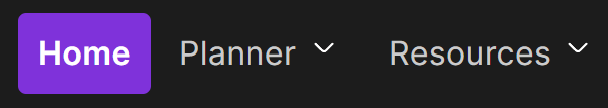

Is a manual text input required in the summary table (as a note for the benchmark selection?)

> Add blockquote



Add callback to store benchmarks from previous selections and be able to rewrite it (avoid repeated rows for the same sku)

Data Upload: allow the user to upload csv or excel sheet

# .py


In [ ]:
from dash import dash, dcc, html, Input, Output, callback, dash_table, no_update, ctx
import plotly.express as px
import json
import dash
import numpy as np
import pandas as pd
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc
from dash import no_update, callback_context
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from dash.exceptions import PreventUpdate

dash.register_page(__name__)

category_dropdown = dcc.Dropdown(
                                id='category-dropdown',

                                placeholder="Select a product category",
                                options=[],

                                style={'width':'100%'})

def create_sku_details_card(sku_info):
    # Assuming 'URL_PICTURE' is the column name for the image URLs
    img_url = sku_info.get('URL_PICTURE', 'https://via.placeholder.com/150')
    return dbc.Card(
        [
            dbc.CardImg(src=img_url, top=True, style={'width': '100%', 'height': 'auto'}),
            dbc.CardBody([
                html.H5(sku_info.get('MODEL', 'N/A'), className="card-title"),
                html.P(f"SKU: {sku_info.get('SKU', 'N/A')}"),
                html.P(f"Family: {sku_info.get('FAMILY', 'N/A')}"),
                html.P(f"Sub Family: {sku_info.get('SUB_FAMILY', 'N/A')}"),
                html.P(f"Main Color: {sku_info.get('MAIN_COLOR', 'N/A')}"),
                html.P(f"Main Material: {sku_info.get('MAIN_MATERIAL', 'N/A')}"),
                dbc.Row([
                    dbc.Col(dbc.Button('Previous',color='warning', id='previous_button', n_clicks=0), md=8),
                    dbc.Col(dbc.Button('Next',color='success', id='next_button', n_clicks=0 ), md=2)
                ])

            ]),
        ],
        className="mb-3", style={'height':'20%'}, id='SKU_card'
    )



search_row = dcc.Dropdown(id="search_SKU", searchable=True, options=[], style={'color': 'black'})





# Define the column structure for the DataTable
benchmark_details_columns = [
    {'name': 'Benchmark SKU', 'id': 'SKU'},  # SKU of the benchmark item
    {'name': 'URL Picture', 'id': 'URL_PICTURE', 'presentation': 'markdown'},  # Image URLs for the benchmark items
    {'name': 'Season', 'id': 'SEASON'},  # Season information for the benchmark items
    {'name': 'Main Color', 'id': 'MAIN_COLOR'},  # Main color of the benchmark items
    {'name': 'Similarity Score', 'id': 'Similarity Score'}  # Similarity score from the model
]

# Create a Dash DataTable to display the benchmarks
benchmark_details_table = dash_table.DataTable(
    id='benchmark-details-table',
    columns=benchmark_details_columns,
    data=[],  # Data will be populated by a callback
    style_table={'overflowX': 'auto', 'overflowY': 'auto', 'height':'500px'},
    style_cell={'textAlign': 'center', 'padding': '5px'},
    style_header={'fontWeight': 'bold', 'backgroundColor': 'rgb(210, 210, 210)'},
    page_size=7,  # Number of rows to display per page
    row_selectable='multi',
    selected_rows=[]


)

# Define the columns for the benchmarks summary table
benchmark_summary_columns = [
    {'name': 'Similar SKUs', 'id': 'SKU'},
    {'name': 'SKU Description', 'id': 'SKU_DESCRIPTION'}

]

# Add a dash DataTable for displaying the summary of stored benchmarks
benchmarks_summary_table = dash_table.DataTable(
    id='benchmarks-summary-table',
    columns=benchmark_summary_columns,
    data=[],  # Initially empty, will be populated by callback
    style_table={'overflowX': 'auto'},
    style_cell={'textAlign': 'left', 'padding': '5px'},
    style_header={'fontWeight': 'bold'}
)

sku_dropdown = dcc.Dropdown(
    id='sku-dropdown',
    placeholder="Select a SKU",
    className="mb-2"
)





layout = html.Div([


    html.H2("Product Benchmarking Dashboard", style={'margin':'2rem'}),
    dbc.Container([



        dbc.Row([

                dbc.Col([



                    html.Div([

                        category_dropdown,

                    ], n_clicks=0, id='update_categories_on_click', style={'margin':'2px'}),

                    html.Div(search_row, style={'margin':'2px'}),
                    html.Div(id='sku-details-card', className="mb-3"),

                ], md='3'),

                dbc.Col([
                    dbc.Row([
                        dbc.Col([



                        ]),
                        dbc.Col([
                            html.Button("Download Selected Benchmarks", id="btn-download")
                        ], width=6)
                    ]),

                    dbc.Row([dbc.Col(benchmark_details_table, width=12)]),  # Place the benchmark details table here
                    dbc.Row([dbc.Col(benchmarks_summary_table, width=12)], className="mt-4")
                ], md='9')
        ]),




        # Dynamic Components

        html.Div(id='selected-data'),
        html.Div(id='temporary-benchmarks-table'),



        # Download
        dcc.Download(id="download-selected-data")
    ])
])



@callback(

    Output('search_SKU', 'options'),
    Input('category-dropdown', 'value'),
    State('preprocessed-data', 'data')
)
def update_dropdown_searchSKU(category, preprocessed_data):

    if category is None:
        return no_update

    df = pd.DataFrame(preprocessed_data)
    df = df[df['ACTIVITY'] == category]

    return df['SKU'].unique()







@callback(
    [
        Output('sku-details-card', 'children'),  # Update the SKU details card
        Output('selected-sku-store', 'data')     # Store the selected SKU
    ],
    [Input('search_SKU', 'value')],
    [State('preprocessed-data', 'data')]
)

def update_sku_details(search_query, preprocessed_data):
    if not preprocessed_data:
        return "Please upload data first.", no_update


    selected_sku = search_query

    if not selected_sku:
        return "Please select a SKU to see details.", no_update

    df_preprocessed = pd.DataFrame(preprocessed_data)

    if 'SKU' in df_preprocessed.columns and selected_sku in df_preprocessed['SKU'].values:
        sku_info = df_preprocessed[df_preprocessed['SKU'] == selected_sku].iloc[0].to_dict()
        card_content = create_sku_details_card(sku_info)  # Use the adjusted function
        return card_content, selected_sku
    else:
        return "SKU details not found. Please select a different SKU.", no_update


@callback(
    Output('benchmark-details-table', 'data'),  # Output: data for the DataTable displaying benchmark details
    [Input('selected-sku-store', 'data'),      # Input: SKU selected from a dropdown
     Input('similarity-matrix-store', 'data')],
    [State('preprocessed-data', 'data'),
     State('similarity_matrix_sku_list', 'data')]
)

def generate_benchmarks(selected_sku_data, similarity_matrix, preprocessed_data, similarity_sku_list):
    if not selected_sku_data or not similarity_matrix or not preprocessed_data:
        return []

    print('Selected SKU:',selected_sku_data)
    df = pd.DataFrame(preprocessed_data)
    similarity_matrix = np.array(similarity_matrix)
    sku_index = df[df['SKU'] == selected_sku_data].index[0]
    print('The SKU index is :',sku_index)

    top_indices = np.argsort(similarity_matrix[sku_index])[::-1][1:41]  # Skip the first index because it's the SKU itself

    print(top_indices)

    benchmarks = df.iloc[top_indices].copy()
    benchmarks['Similarity Score'] = similarity_matrix[sku_index][top_indices]
    benchmarks['URL_PICTURE'] = '![NA](' + benchmarks['URL_PICTURE'].astype(str) + ')'


    return benchmarks.to_dict('records')



 # Triggered by Category Selection E.g. ACCESORIES
 #One Hot Encoding preprocessed data, weighting, Applying PCA, Calculate cosine similarity from PCA features & Applying get_benchmarks() function

@callback(
    [Output('similarity-matrix-store', 'data'),
     Output('similarity_matrix_sku_list', 'data')],  # Store the similarity matrix
    Input('category-dropdown', 'value'),  # Triggered by category selection
    State('preprocessed-data', 'data')  # Uses preprocessed data as a state
)

def compute_similarity_matrix(selected_category, preprocessed_data):
    if not preprocessed_data or not selected_category:
        return no_update

    # Convert preprocessed data into DataFrame
    df = pd.DataFrame(preprocessed_data)

    # Filter data based on selected category
    if selected_category:
        df = df[df['ACTIVITY'] == selected_category]
        if df.empty:
            return no_update  # Return if no data is available for the selected category

    # Define categorical features based on the DataFrame's columns or fixed list
    categorical_features = ['FAMILY', 'GENDER', 'MACRO_AESTHETIC_LINE', 'MAIN_COLOR', 'MATERIAL_GROUP', 'SEASONALITY', 'REAL_MONTH']
    df[categorical_features] = df[categorical_features].astype(str)

    # Initialize OneHotEncoder
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    encoded_features = one_hot_encoder.fit_transform(df[categorical_features])



    # Create a DataFrame from the encoded features, adding back the SKU
    encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=df.index)
    encoded_df['SKU'] = df['SKU']  # Add the SKU as a column to the encoded features DataFrame

    # Dynamic weights based on selected category
    if selected_category == 'ACCESSORIES':
        weights = np.array([10, 1, 1, 5, 1, 1, 1])  # Adjusted weights for ACCESSORIES
    elif selected_category == 'LEATHER GOODS':
        weights = np.array([5, 2, 2, 1, 10, 2, 1])  # Adjusted weights for LEATHER GOODS
    else:
        weights = np.array([1, 1, 1, 1, 1, 1, 1])  # Default weights if category is not recognized

    # Calculate the repetition of weights according to unique categories
    unique_values_counts = [one_hot_encoder.categories_[i].size for i in range(len(categorical_features))]
    repeated_weights = np.repeat(weights, unique_values_counts)

    # Apply weights
    weighted_encoded_features = encoded_df.iloc[:, :-1] * repeated_weights  # Exclude 'SKU' from weighting
    weighted_encoded_df = pd.concat([encoded_df[['SKU']], weighted_encoded_features], axis=1)

    # Apply PCA
    pca = PCA(n_components=0.95)
    sku_list = weighted_encoded_df['SKU'].to_list()
    pca_features = pca.fit_transform(weighted_encoded_df.drop('SKU', axis=1))

    # Calculate cosine similarity from PCA features
    similarity_matrix_pca = cosine_similarity(pca_features)

    return similarity_matrix_pca.tolist(), sku_list  # Storing as list for JSON compatibility









@callback(
    Output('category-dropdown', 'options'),  # Store the similarity matrix
    Input('update_categories_on_click', 'n_clicks'),  # Triggered by category selection
    State('category-options', 'data')
)
def update_category_list(n_click, data):
    if n_click != 0:
        return data

    return {}


@callback(

    [Output('stored-selected-rows', 'data'),
     Output('benchmarks-summary-table', 'data')],
    Input('benchmark-details-table', 'selected_rows'),
    [State('selected-sku-store', 'data'),
     State('benchmark-details-table', 'data')]

)
def save_selected_benchmarks(selected_row_indices, target_SKU, benchmark_detials_table):

    df = pd.DataFrame(benchmark_detials_table)

    if selected_row_indices:
        df = df.loc[selected_row_indices]
        df['target_SKU'] = target_SKU

        return df.to_dict('records'), df.to_dict('records')

    return no_update








@callback(
        Output('search_SKU', 'value'),
        [Input('next_button', 'n_clicks'),
         Input('previous_button', 'n_clicks')],
        [State('search_SKU', 'options'),
         State('selected-sku-store', 'data')]
)
def next_prev_button_action(n_clicks_next, n_clicks_prev,list_options, current_sku):

    if n_clicks_next == 0 and n_clicks_prev == 0:
        return dash.no_update

    button_clicked = ctx.triggered_id



    try:
        current_index = list_options.index(current_sku)


        if button_clicked == 'next_button' and current_index < len(list_options)-1:
            return list_options[current_index + 1]
        elif button_clicked == 'previous_button' and current_index > 0:
                return list_options[current_index - 1]

        return dash.no_update

    except (ValueError, IndexError):
        # ValueError if the current_value is not in the list,
        # IndexError if trying to access beyond the list

        return dash.no_update





@callback(

    [Output('next_button', 'color'),
     Output('previous_button', 'color')],
    Input('SKU_card', 'children'),
    [State('search_SKU', 'value'),
     State('search_SKU', 'options')]

)
def check_for_button_color(sku_card, current_sku, sku_options_list):

    current_index = sku_options_list.index(current_sku)

    if current_index == len(sku_options_list)-1:
        return 'secondary', 'warning'
    elif current_index == 0:
        return 'success', 'secondary'
    else:
        return 'success', 'warning'